## Fitting method

## Control Variables : <font color = 'sky blue'> $n_e,n_+,n_-,T_e, T_+,T_-, m_+,m_-$ </font>
<font size="2">
    [1] <a href="https://sci-hub.st/https://aip.scitation.org/doi/10.1063/1.4802252"> [2013] Langmuir probe analysis of highly electronegative plasmas</a> <br>
    [2] <a href="https://sci-hub.st/https://doi.org/10.1063/1.4903328"> [2014] Langmuir probe analysis in electronegative plasmas</a> <br><br>
    
Number of control variables can be reduced by set $m_+,m_-$ and $n_+ =n_e+n_-$ <br>
Ion composition setup : $SF_5^+,SF_5^-$ and m=127AMU<br>
Fitting error within 5%

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from const import *
import method
import plotting
import ldf
import importlib

importlib.reload(plotting)
importlib.reload(method)
importlib.reload(ldf)

<module 'ldf' from 'c:\\Users\\GUNU\\PythonProjects\\negative-ion\\ldf.py'>

## 계산될 Parameter

In [31]:
Vp = 0
ne = 1e15
nm = 7e16
Te = 6
Tp = 0.1
Tm = 0.1

In [38]:
workDir = './211216(SF6)/bias (float) 0mm B-field/'
#workDir = './211221(SF6)/SF6/Radial Scan_15sccm/'
parser = ldf.parser(workDir)
ldf_list = parser.ldf_paths()

file = ldf_list[0]
IV, imported_eedf, result = parser.pull_attr(file, need_return=True)
processor = ldf.processor(IV)
V, IV_second_derivative = processor.cal_second_derivative()

fit1 = method.fitting(IV, V, IV_second_derivative)

V_list1 = np.linspace(-5, 0, 100)
V_list2 = np.linspace(0,5,100)
V_list = np.unique(np.concatenate((V_list1,V_list2)))
I_list, I_p_list, I_e_list, I_n_list = [], [], [], []

File import success


In [39]:
for V in V_list:
    I_p_list.append(fit1.positive_ion_current(V, ne, nm, Te, Tp, Tm, Vp))
    I_e_list.append(fit1.electron_current(V, ne, Te, Vp))
    I_n_list.append(fit1.negative_ion_current(V, ne, nm, Te, Tm, Vp))
    I_list.append(fit1.total_current(V, ne, nm, Te, Tp, Tm, Vp))

ValueError: A value in x_new is below the interpolation range.

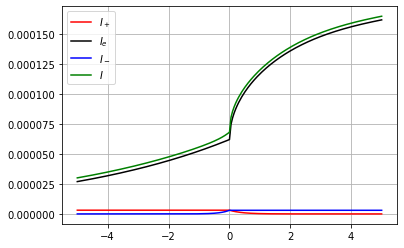

In [24]:
plt.figure(figsize=(6, 4))
plt.plot(V_list, I_p_list, c='r')
plt.plot(V_list, I_e_list, c='k')
plt.plot(V_list, I_n_list, c='b')
plt.plot(V_list, I_list, c='g')
plt.grid(1)
plt.legend(['$I_+$', '$I_e$', '$I_-$', '$I$'])